# 等距映射(Isometric Mapping, ISOMAP)

## 符号定义

## 概念

ISOMAP在MDS的基础上发展而来。最为原始的MDS采用欧氏距离计算两点间的距离。欧式距离是欧氏空间中两点间的直线距离，但是对于MDS这类流形降维方法，通常假设数据是低维流形镶嵌在高维空间中的结果，因此使用欧式距离直接计算两点之间的距离略为不妥。

在MDS的基础上，将距离度量方式由欧氏距离换为测地线或许是更好的选择，即在降维过程中不再是保持两点间的直线距离不变，而是保持两点间的“测地线距离”不变。由此提出ISOMAP算法。

ISOMAP中，使用**近似**测地线代替欧式距离对两点之间的距离进行度量。之所以称之为**近似**测地线，是因为对于由数据点构成的数据集来说，测地线无法直接得到。在ISOMAP算法中，实际采用的是**最短路径距离**。得到两两数据点之间的距离后，使用类似于MDS中使用的优化方法即可得到降维后的结果。

显然ISOMAP包含两个重要步骤：
* 在原空间中计算两两数据点之间的最短路径距离；
* 在低维空间中寻找一个集合，这个集合中任意两点之间的最短路径距离与其相对应的高维空间中的距离尽可能相同。

类似于MDS，上述第一步为“关系”的定义；第二步是一个优化问题。

## 推导

## 算法流程

In [1]:
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.neighbors import NearestNeighbors

In [2]:
class MyISOMAP(object):

    def __init__(self):
        pass

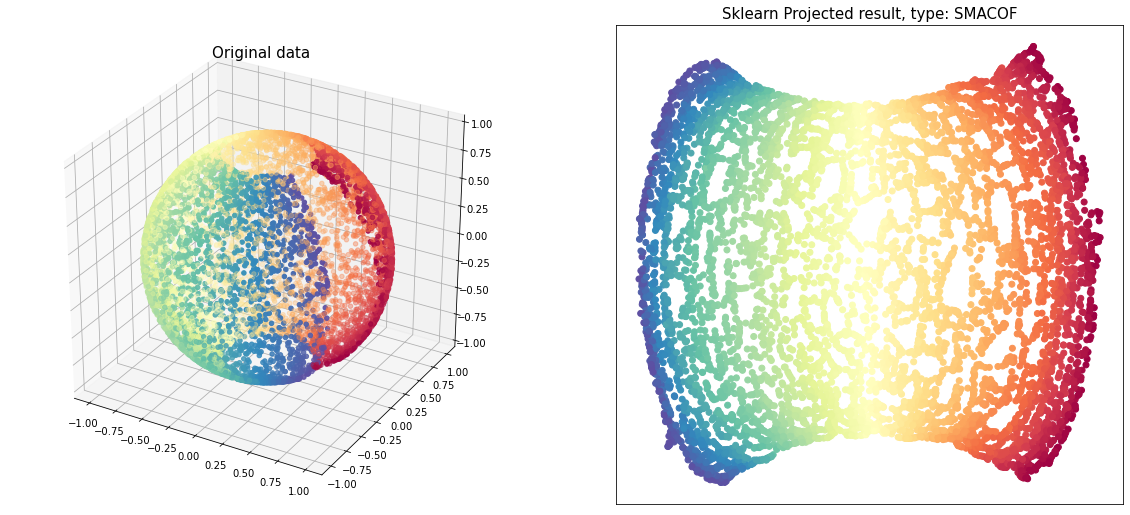

In [3]:
# ---------------------- create data ----------------------
n_samples = 3000

# Create our sphere.
np.random.seed = 1024
p = np.random.rand(n_samples) * (2 * np.pi - 0.55)
t = np.random.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = (t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8)))
samples_color = p[indices]
x, y, z = (
    np.sin(t[indices]) * np.cos(p[indices]),
    np.sin(t[indices]) * np.sin(p[indices]),
    np.cos(t[indices]),
)
raw_samples = np.array([x, y, z]).T

#  ---------------------- sklearn ISOMAP ---------------------- 
sklearn_isomap = manifold.Isomap(n_neighbors=5, n_components=2)
sklearn_isomap_result = sklearn_isomap.fit_transform(raw_samples)

# ----------------------
# draw func
fig = plt.figure(figsize=(20, 30))

ax = fig.add_subplot(321, projection="3d")
ax.set_title("Original data", fontsize=15)
ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(322)
plt.xticks([])
plt.yticks([])
plt.title("Sklearn Projected result, type: SMACOF", fontsize=15)
ax.scatter(sklearn_isomap_result[:, 0], sklearn_isomap_result[:, 1], c=samples_color, cmap=plt.cm.Spectral)

# ax = fig.add_subplot(323, projection="3d")
# ax.set_title("Original data", fontsize=15)
# ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

# ax = fig.add_subplot(324)
# plt.xticks([])
# plt.yticks([])
# plt.title("My Projected result, type: Gradient Descent", fontsize=15)
# ax.scatter(my_mds_result_iter_type[:, 0], my_mds_result_iter_type[:, 1], c=samples_color, cmap=plt.cm.Spectral)


# ax = fig.add_subplot(325, projection="3d")
# ax.set_title("Original data", fontsize=15)
# ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

# ax = fig.add_subplot(326)
# plt.xticks([])
# plt.yticks([])
# plt.title("My Projected result, type: Eigen Decomposition", fontsize=15)
# ax.scatter(my_mds_result_inner_type[:, 0], my_mds_result_inner_type[:, 1], c=samples_color, cmap=plt.cm.Spectral)

plt.show()